# **Loading the dataset**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
dataset_path = '/content/drive/MyDrive/path/to/dataset'

In [3]:
!pip install mtcnn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 46.1 MB/s eta 0:00:00


In [4]:
## Importing all the libraries

import cv2 as cv
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

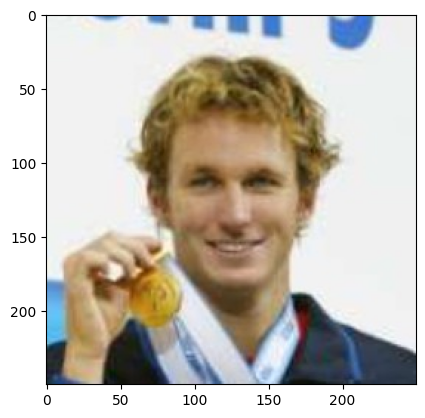

In [5]:
img = cv.imread('/content/drive/MyDrive/path/to/img.jpg')
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

plt.imshow(img)

In [6]:
from mtcnn.mtcnn import MTCNN

detector = MTCNN()
results = detector.detect_faces(img)

1/1 [==============================] - 0s 145ms/step


In [7]:
results

[{'box': [81, 68, 87, 115],
  'confidence': 0.9998226165771484,
  'keypoints': {'left_eye': (106, 113),
   'right_eye': (145, 112),
   'nose': (128, 140),
   'mouth_left': (108, 153),
   'mouth_right': (148, 152)}}]

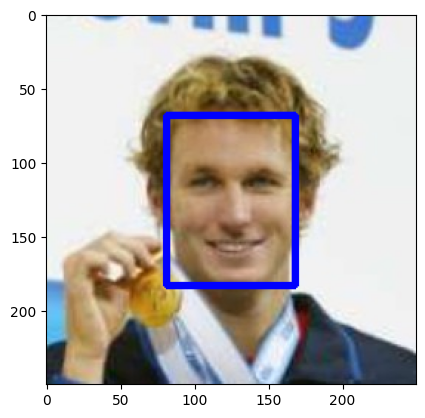

In [8]:
x,y,w,h = results[0]['box']
img = cv.rectangle(img, (x,y), (x+w, y+h), (0,0,255), 3)
plt.imshow(img)

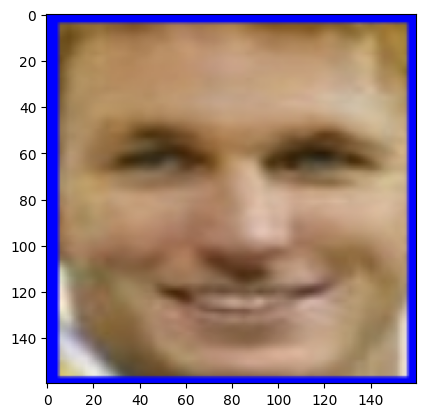

In [9]:
#Extracting the face

face = img[y:y+h, x:x+w]

## facenet takes image of size 160x160. So we will now resize the image
face = cv.resize(face, (160,160))
plt.imshow(face)

# **Automate the whole preprocessing**

In [10]:
class Faceloading:
  def __init__(self, directory):
    self.directory = directory
    self.target_size = (160,160)
    self.X = []
    self.Y = []
    self.detector = MTCNN()

  def extract_face(self, filename):
    img = cv.imread(filename)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    x, y, w, h = self.detector.detect_faces(img)[0]['box']
    x,y = abs(x), abs(y)
    face = img[y:y+h, x:x+w]
    face_arr = cv.resize(face, self.target_size)
    return face_arr

  def load_faces(self, dir):
    FACES = []
    for im_name in os.listdir(dir):
      try:
        path = dir + im_name
        single_face = self.extract_face(path)
        FACES.append(single_face)
      except Exception as e:
        pass
    return FACES

  def load_classes(self):
    for sub_dir in os.listdir(self.directory):
      path = self.directory + '/' + sub_dir + '/'
      FACES = self.load_faces(path)
      labels = [sub_dir for _ in range(len(FACES))]
      print(f"Loaded Successfully: {len(FACES)}")
      self.X.extend(FACES)
      self.Y.extend(labels)

    return np.asarray(self.X), np.asarray(self.Y)

  def plot_images(self):
    for num, image in enumerate(self.X):
      ncols = 3
      nrows = len(self.Y)//ncols
      plt.subplot(nrows, ncols, num+1)
      plt.imshow(image)
      plt.axis('off')

In [11]:
face_loading = Faceloading('/content/drive/MyDrive/path/to/dataset')
X, Y = face_loading.load_classes()

1/1 [==============================] - 0s 100ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 65ms/step
Loaded Successfully: 3
1/1 [==============================] - 0s 28ms/step
Loaded Successfully: 4
1/1 [==============================] - 0s 43ms/step
Loaded Successfully: 2
1/1 [==============================] - 0s 31ms/step
Loaded Successfully: 19
1/1 [==============================] - 0s 55ms/step
Loaded Successfully: 3
1/1 [==============================] - 0s 29ms/step
Loaded Successfully: 4
1/1 [==============================] - 0s 28ms/step
Loaded Successfully: 4
1/1 [==============================] - 0s 70ms/step
Loaded Successfully: 2
1/1 [==============================] - 0s 51ms/step
Loaded Successfully: 2
1/1 [==============================] - 0s 34ms/step
Loaded Successfully: 2
1/1 [==============================] - 0s 30ms/step
Loaded Successfully: 3
1/1 [==============================] - 0s 32ms/step
Loaded Successfully: 3
1/1 [==============================] - 0s 49ms/step
Loaded Successfully: 2
1/1 [===================

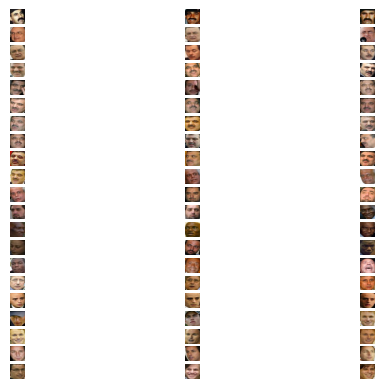

In [12]:
face_loading.plot_images()

# **FaceNet Model Architecture**

In [13]:
!pip install keras-facenet

  Preparing metadata (setup.py) ... done
  Created wheel for keras-facenet: filename=keras_facenet-0.3.2-py3-none-any.whl size=10370 sha256=f1ea7732b27d269b79b3505a1538a3fda66da3ccfb898dd973d8f3550c014ec0
  Stored in directory: /root/.cache/pip/wheels/1d/d8/a9/85cf04ea29321d2afcb82c0caaafdca9195385f9d68cbc7185
Successfully built keras-facenet


In [14]:
from keras_facenet import FaceNet
embedder = FaceNet()

def get_embedding(face_img):
  face_img = face_img.astype('float32')
  face_img = np.expand_dims(face_img, axis=0)
  yhat = embedder.embeddings(face_img)
  return yhat[0]

In [15]:
EMBEDDED_X = []

for img in X:
  EMBEDDED_X.append(get_embedding(img))

EMBEDDED_X = np.asarray(EMBEDDED_X)


1/1 [==============================] - 0s 83ms/step


In [16]:
np.savez_compressed('faces_embedding_done.npz', EMBEDDED_X, Y)

# **KNN Model**

To compare the face embeddings and get the accuracy score

In [21]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
encoder.fit(Y)
Y = encoder.transform(Y)
Y

array([15, 15, 15, 14, 14, 14, 14, 13, 13, 12, 12, 12, 12, 12, 12, 12, 12,
       12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 11, 11, 11, 10, 10, 10,
       10,  9,  9,  9,  9,  8,  8,  7,  7,  6,  6,  5,  5,  5,  4,  4,  4,
        3,  3,  0,  0,  0,  0,  2,  2,  2,  2,  1,  1])

In [38]:
from sklearn.model_selection import train_test_split

In [42]:
# from sklearn.svm import SVC

# model = SVC(kernel='poly', probability = True)
# model.fit(X_train, Y_train)

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
EMBEDDED_X_normalized = scaler.fit_transform(EMBEDDED_X)

X_train, X_test, Y_train, Y_test = train_test_split(EMBEDDED_X_normalized, Y, test_size = 0.2, shuffle = True, random_state = 42)

knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, Y_train)

ypreds_train = knn.predict(X_train)
ypreds_test = knn.predict(X_test)


In [43]:
from sklearn.metrics import accuracy_score

accuracy_score(Y_train, ypreds_train)

0.96

In [44]:
accuracy = accuracy_score(Y_test, ypreds_test)
accuracy

0.8461538461538461